In [14]:
import sys
sys.path.insert(0, '../')

import csaps
import typing
import numpy as np
import numpy
import scipy
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

import pandas as pd

from src.vg2signal import read_raw_vg_as_df, make_detilter, make_smoother

In [13]:
def make_shoulder_getter(vstart: float,
                         vend: float) -> typing.Callable:
    def shoulder_getter_func(v: numpy.array,
                             lisd: numpy.array):
        v_in = numpy.logical_and(v >= vstart, v <= vend)
        spline_model = scipy.interpolate.UnivariateSpline(v[v_in],
                                                          lisd[v_in],
                                                          s=0,
                                                          k=4)

        v_peak = None
        # we are looking for a local minimum of the third derivative between
        # vstart and vend
        spl_mdl_dd = spline_model.derivative(n=2)
        spl_mdl_dd_pred = spl_mdl_dd(v[v_in])

        spl_mdl_ddd = spline_model.derivative(n=3)
        spl_mdl_ddd_pred = spl_mdl_ddd(v[v_in])
        spl_mdl_ddd_b = scipy.interpolate.splrep(v[v_in],
                                                 spl_mdl_ddd_pred)
        spl_mdl_ddd_ppoly = scipy.interpolate.PPoly.from_spline(spl_mdl_ddd_b)
        roots_ddd = spl_mdl_ddd_ppoly.roots(extrapolate=False)
        if len(roots_ddd) == 1:
            v_peak = float(roots_ddd[0])
        elif len(roots_ddd) > 1:
            minsecond = min(spl_mdl_dd_pred)
            idx = (numpy.abs(spl_mdl_dd_pred - minsecond)).argmin()
            vin = list(v[v_in])
            v_peak = vin[idx]
        else:
            minsecond = min(spl_mdl_dd_pred)
            idx = (numpy.abs(spl_mdl_dd_pred - minsecond)).argmin()
            vin = list(v[v_in])
            v_peak = vin[idx]
            print("WARNING: no roots found")
        return (None, v_peak)
    return shoulder_getter_func


In [2]:
def check_signal_validity(vg_filename: str,
             do_log: bool,
             smoothing_bw: float,
             vcenter: float,
             vwidth: float,
             stiffness: float):

    vg_df = read_raw_vg_as_df(vg_filename)

    if (vg_df['I'].to_numpy() < 0).any():
        temp = [None] * 11
        return None

    if do_log:
        cur_var_name = "logI"
        #vg_df[cur_var_name] = np.emath.logn(logbase, vg_df["I"])
        vg_df[cur_var_name] = np.log2(vg_df["I"])
    else:
        cur_var_name = "I"

    smoother = make_smoother(smoothing_bw)

    vg_df["smoothed"] = smoother(vg_df["V"], vg_df[cur_var_name].to_numpy())

    shoulder_getter = make_shoulder_getter(1, 1.1)
    (peak_signal, peak_v_shoulder) = shoulder_getter(vg_df["V"],
                                                     vg_df["smoothed"])

    vcenter = peak_v_shoulder
    vstart = vcenter - 0.5*vwidth
    vend = vcenter + 0.5*vwidth

    detilter = make_detilter(vstart, vend, stiffness)
    vg_df["detilted"] = detilter(vg_df["V"].to_numpy(),
                                 vg_df["smoothed"].to_numpy())
    
    max_signal = vg_df['detilted'].max()  
    min_signal = vg_df['detilted'].min()

    # Invalid data sample when the signal has negative peak higher than positive and has threshold above 0.009
    return (True if (abs(min_signal) > abs(max_signal)) and (abs(min_signal)>0.009) else False), vg_df


def make_detilter(vstart: float,
                  vend: float,
                  stiffness: float) -> typing.Callable:
    assert stiffness >= 0.0, \
        "invalid stiffness parameter (should be " + \
        f"greater than zero): {stiffness}"

    def detilter_func(v: numpy.array, lis: numpy.array):
        v_out  = numpy.logical_or(v < vstart, v > vend)
        lis_bg = csaps.csaps(v[v_out], lis[v_out], v,
                             smooth=(1.0 / (1.0 + stiffness)))
        return (lis - lis_bg), lis_bg

    return detilter_func

In [3]:
# do_log        = True
# recenter      = False
# smoothing_bw  = 0.006
# stiffness     = 1
# vcenter       = 1.04
# vwidth1       = 0.18

# root_path     = '/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset'
# filename_path = [*glob(f'{root_path}/ML1_ML2/2024_02_19_ML1/*.txt'), *glob(f'{root_path}/ML1_ML2/2024_02_22_ML2/*.txt'), *glob(f'{root_path}/ML4/*.txt')]

# list_of_invalid_data = []

# for filename in filename_path:
#     is_invalid, _       = check_signal_validity(filename,
#                             do_log,
#                             smoothing_bw,
#                             vcenter,
#                             vwidth1,
#                             stiffness)
        
#     if is_invalid==None: continue
#     if is_invalid: list_of_invalid_data.append(filename)

In [181]:
from src.generate_dataset import v2signal_extra_features
from scipy.signal import savgol_filter, medfilt
from scipy.interpolate import UnivariateSpline

/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1/2024_02_19_cbz08_37.txt
Inside Fun 0.0002446317527846631
-1.4089133345274985 34.4207916859166


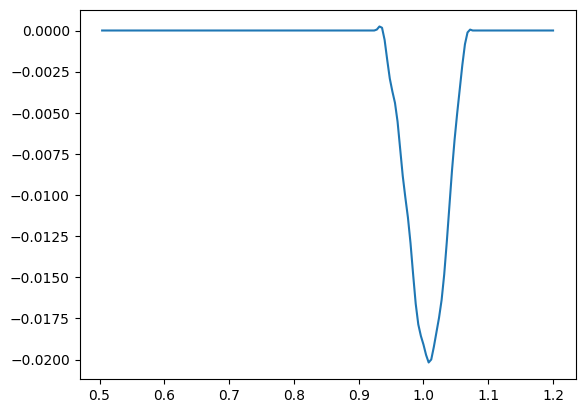

In [364]:
from glob import glob
import os

do_log        = True
recenter      = False
smoothing_bw  = 0.006
stiffness     = 0
vcenter       = 1.04
vwidth1       = 0.15

file     = '2024_02_19_cbz08_37' #'2024_02_22_cbz08_16.txt'
root_path     = os.path.realpath('../dataset')
filename_path = [*glob(f'{root_path}/ML1_ML2/2024_02_19_ML1/*.txt'), *glob(f'{root_path}/ML1_ML2/2024_02_22_ML2/*.txt'), *glob(f'{root_path}/ML4/*.txt')]


filename = [pathname for pathname in filename_path if (file in pathname)][0]

print(filename)
(peak_signal, peak_curvature, peak_v, vg_df, vcenter, ph, signal_mean, signal_std,\
                dS_dV_max_peak, dS_dV_min_peak, dS_dV_peak_diff, dS_dV_max_V, \
                dS_dV_min_V, dS_dV_area) = v2signal_extra_features(filename,
                                                                    do_log,
                                                                    smoothing_bw,
                                                                    vcenter,
                                                                    vwidth1,
                                                                    stiffness)

# if abs(vg_df['detilted'].min()) > abs(vg_df['detilted'].max()):
#     vg_df['detilted'] = -vg_df['detilted'] # Flip the signal

print(peak_signal, peak_curvature)
plt.plot(vg_df['V'], vg_df['detilted'])

In [365]:
def calculate_peak_curvature(x, y):
    # Compute first derivatives of x and y
    dx = np.gradient(x)
    dy = np.gradient(y)
    
    # Compute second derivatives of x and y
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    
    # Compute curvature
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3/2)
    
    # Find the index of the peak curvature
    peak_curvature_idx = np.argmax(curvature)
    peak_curvature     = curvature[peak_curvature_idx]

    return peak_curvature, peak_curvature_idx

In [366]:
vstart = 1
vend   = 1.1
v    = vg_df['V']
lisd = vg_df['smoothed']

v_in = numpy.logical_and(v >= vstart, v <= vend)

peak_curvature, peak_curvature_idx = calculate_peak_curvature(v[v_in], lisd[v_in])
v_peak = v[v_in].iloc[[peak_curvature_idx]].to_list()[0]
print(v_peak)

1.008


[1.00941841 1.01933456 1.02943769 1.04627649 1.05563743 1.06620832
 1.07904943 1.08433503]
-34.80573524396681
1.0


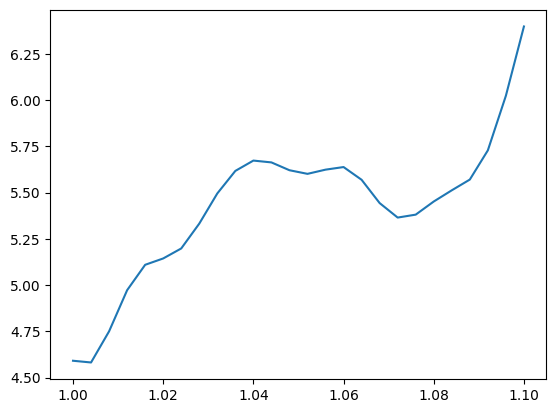

In [394]:
vstart = 1
vend   = 1.1
v    = vg_df['V']
lisd = vg_df['smoothed']

v_in = numpy.logical_and(v >= vstart, v <= vend)

spline_model = scipy.interpolate.UnivariateSpline(v[v_in],
                                                          lisd[v_in],
                                                          s=0,
                                                          k=4)

v_peak = None
# we are looking for a local minimum of the third derivative between
# vstart and vend
spl_mdl_dd      = spline_model.derivative(n=1)
spl_mdl_d_pred  = spl_mdl_dd(v[v_in])

plt.plot(v[v_in], spl_mdl_d_pred)

spl_mdl_dd      = spline_model.derivative(n=2)
spl_mdl_dd_pred = spl_mdl_dd(v[v_in])


# plt.plot(v[v_in], spl_mdl_dd_pred, c='blue')

spl_mdl_ddd      = spline_model.derivative(n=3)
spl_mdl_ddd_pred = spl_mdl_ddd(v[v_in])
spl_mdl_ddd_b    = scipy.interpolate.splrep(v[v_in],
                                          spl_mdl_ddd_pred)



spl_mdl_ddd_ppoly = scipy.interpolate.PPoly.from_spline(spl_mdl_ddd_b)
roots_ddd         = spl_mdl_ddd_ppoly.roots(extrapolate=False)

print(roots_ddd)

if len(roots_ddd) == 1:
    v_peak = float(roots_ddd[0])

elif len(roots_ddd) > 1:
    minsecond = min(spl_mdl_dd_pred)
    print(minsecond)
    idx = (numpy.abs(spl_mdl_dd_pred - minsecond)).argmin()
    vin = list(v[v_in])
    v_peak = vin[idx]

else:
    minsecond = min(spl_mdl_dd_pred)
    idx = (numpy.abs(spl_mdl_dd_pred - minsecond)).argmin()
    vin = list(v[v_in])
    v_peak = vin[idx]
    print("WARNING: no roots found")


print(v_peak)

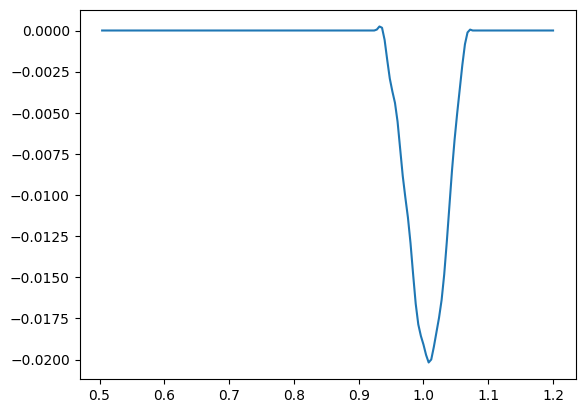

In [368]:
# stiffness       = 0
# shoulder_getter = make_shoulder_getter(1, 1.1)
(peak_signal, peak_v_shoulder) = None, v_peak#shoulder_getter(vg_df["V"],
                                                    # vg_df["smoothed"])

vwidth  = vwidth1

vcenter = peak_v_shoulder
vstart  = vcenter - 0.5*vwidth
vend    = vcenter + 0.5*vwidth

v  = vg_df["V"].to_numpy()
lis= vg_df["smoothed"].to_numpy()

v_out  = numpy.logical_or(v < vstart, v > vend)
lis_bg = csaps.csaps(v[v_out], lis[v_out], v,
                     smooth=(1.0 / (1.0 + stiffness)))

detilter = lis - lis_bg

plt.plot(v, detilter)

1.0
       V      I      logI  smoothed  detilted
124  1.0  4.487  2.165751  2.164541 -0.019092


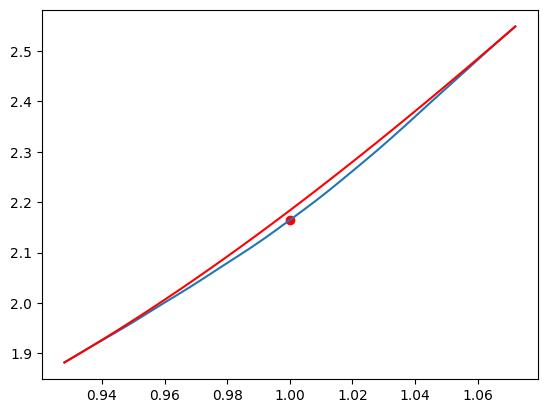

In [369]:
clip_mask = (vg_df['V'] > vstart) & (vg_df['V'] < vend)

signal_peak = vg_df[vg_df['V']==vcenter]

print(vcenter)
print(signal_peak)


plt.plot(vg_df['V'][clip_mask], vg_df['smoothed'][clip_mask])
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='red')
plt.plot(vg_df['V'][clip_mask], lis_bg[clip_mask], c='red', )

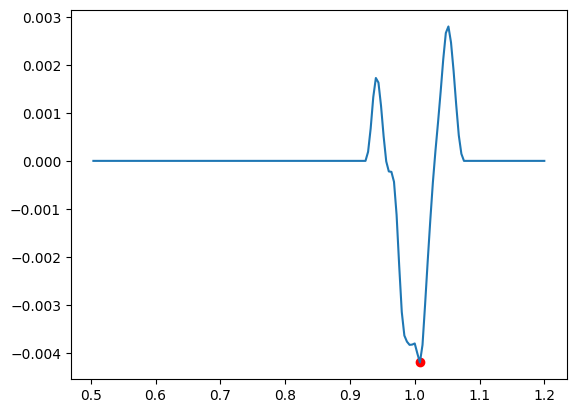

In [237]:
signal_peak = vg_df[vg_df['V']==vcenter]
plt.plot(vg_df['V'], vg_df['detilted'])
plt.scatter(signal_peak['V'], signal_peak['detilted'], c='red')

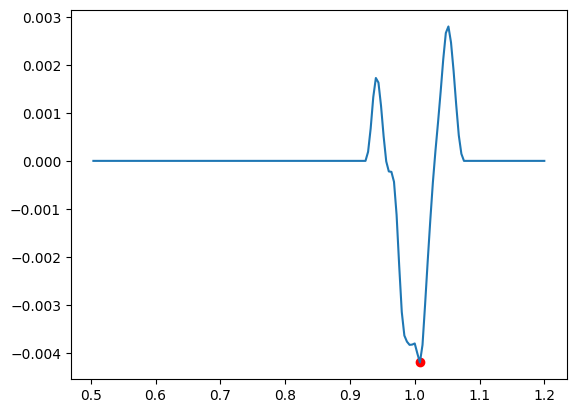

In [238]:
signal_peak = vg_df[vg_df['V']==vcenter]
plt.plot(vg_df['V'], vg_df['detilted'])
plt.scatter(signal_peak['V'], signal_peak['detilted'], c='red')

0.9344184129589335 1.0844184129589334


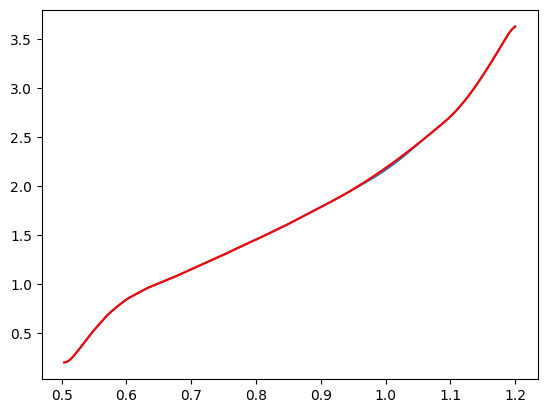

In [111]:
clip_mask = (vg_df['V'] > vstart) & (vg_df['V'] < vend)

signal_peak = vg_df[vg_df['V']==vcenter]

plt.plot(vg_df['V'], vg_df['smoothed'])
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='red')
plt.plot(vg_df['V'], lis_bg, c='red', )

print(vstart, vend)
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='green')

signal_peak = vg_df[vg_df['V']==vend]
plt.scatter(signal_peak['V'], signal_peak['smoothed'], c='green')

In [112]:
vg_df['V'].max()

1.2

In [ ]:
plt.plot(vg_df['V'], vg_df['detilted'])

In [ ]:
plt.plot(vg_df['V'], vg_df['detilted'].clip(lower=0.0))

# Analyze finding peak curvature in more detail

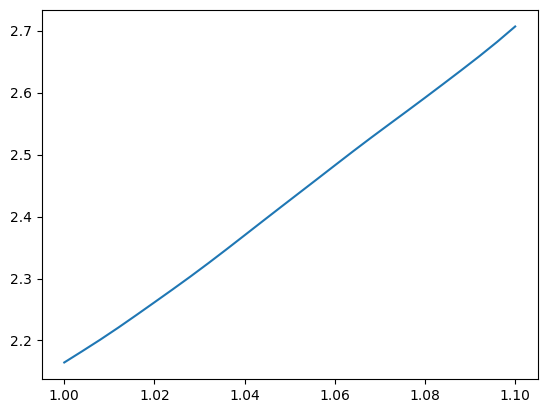

In [401]:
x, y = vg_df['V'], vg_df['smoothed']
v_in = (x >= 1) & (x <= 1.1)

x, y = x[v_in], y[v_in]
spline_model = scipy.interpolate.UnivariateSpline(x,
                                                          y,
                                                          s=0,
                                                          k=4)

plt.plot(x, y)

In [402]:
# print(x[y.argmax()])

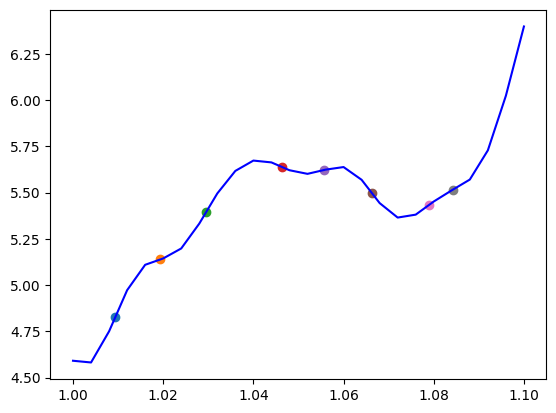

In [403]:
spl_mdl_d      = spline_model.derivative(n=1)
spl_mdl_d_pred = spl_mdl_d(x)
plt.plot(x, spl_mdl_d_pred, c='blue')
for i in roots_ddd:
    plt.scatter(i, spl_mdl_d(i))

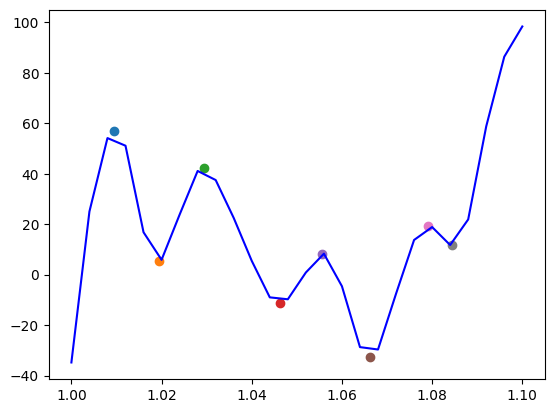

In [404]:
spl_mdl_dd      = spline_model.derivative(n=2)
spl_mdl_dd_pred = spl_mdl_dd(x)


plt.plot(x, spl_mdl_dd_pred, c='blue')
for i in roots_ddd:
    plt.scatter(i, spl_mdl_dd(i))

In [405]:
x.iloc[spl_mdl_dd_pred.argmin()], spl_mdl_dd_pred.min()

(1.0, -34.80573524396681)

In [408]:
spl_mdl_ddd      = spline_model.derivative(n=3)
spl_mdl_ddd_pred = spl_mdl_ddd(x)
spl_mdl_ddd_b    = scipy.interpolate.splrep(x,
                                          spl_mdl_ddd_pred)



spl_mdl_ddd_ppoly = scipy.interpolate.PPoly.from_spline(spl_mdl_ddd_b)
roots_ddd         = spl_mdl_ddd_ppoly.roots(extrapolate=False)

print(roots_ddd)

[1.00941841 1.01933456 1.02943769 1.04627649 1.05563743 1.06620832
 1.07904943 1.08433503]


In [409]:
roots_ddd[spl_mdl_dd(roots_ddd).argmin()]

1.0662083234391184

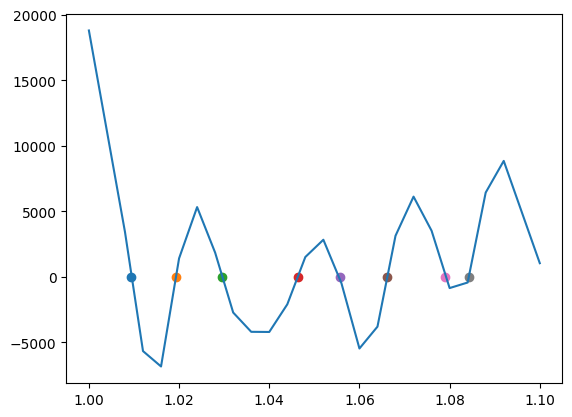

In [410]:
plt.plot(x, spl_mdl_ddd_ppoly(x))
for i in roots_ddd:
    plt.scatter(i, spl_mdl_ddd_ppoly(i))

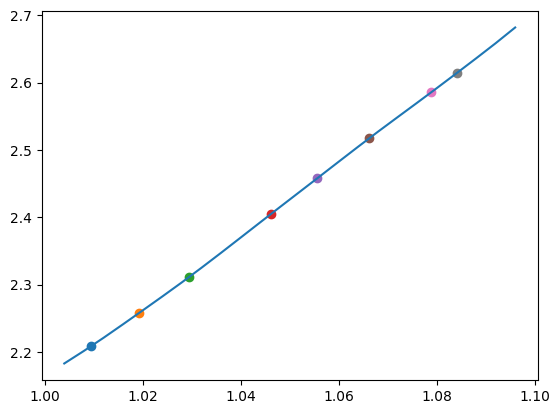

In [393]:

plt.plot(x, y)
for i in roots_ddd:
    plt.scatter(i, spline_model(i))